In [1]:
import json
import wget

In [2]:
data_link = "https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json"
local_path = "/Users/rolandopineda/CS299/week7/lab-w7"

wget.download(data_link, out=local_path)

'/Users/rolandopineda/CS299/week7/lab-w7/sarcasm.json'

In [3]:
with open("sarcasm.json",'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [4]:
training_size = 20000

vocab_size = 10000

max_length = 32

embedding_dim = 16


In [5]:
# Splitting data set

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [7]:
# Parameters for padding and OOV tokens

trunc_type ='post'
padding_type="post"
oov_tok='<OOV>'

# Initializing tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generates the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generates and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences,  maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into np arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [8]:
import tensorflow as tf

# Initialize a Global AveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# print shape and contents of sample array
print(f'shape of sample array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# {ass sample array to gap1d layer
output = gap1d_layer(sample_array)

# Print shape and contents of GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
Metal device set to: Apple M1
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


2022-04-22 19:01:04.543624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-22 19:01:04.544946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Creating a call back class to stop overfitting
class myCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('loss') < 0.01):
            print("\n Loss is now cancelling training!")
            self.model.stop_training = True

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 16)            160000    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 24)                12312     
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 172,337
Trainable params: 172,337
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
num_epochs = 20
callbacks = myCallBack()
# Training the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/20


2022-04-22 19:01:05.041448: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-22 19:01:05.405949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.7899

2022-04-22 19:01:15.160990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 11s 16ms/step - loss: 0.4274 - accuracy: 0.7899 - val_loss: 0.3127 - val_accuracy: 0.8657
Epoch 2/20
625/625 [==============================] - 9s 14ms/step - loss: 0.1953 - accuracy: 0.9226 - val_loss: 0.3247 - val_accuracy: 0.8596
Epoch 3/20
625/625 [==============================] - 8s 14ms/step - loss: 0.0924 - accuracy: 0.9691 - val_loss: 0.3802 - val_accuracy: 0.8591
Epoch 4/20
625/625 [==============================] - 8s 13ms/step - loss: 0.0343 - accuracy: 0.9910 - val_loss: 0.4743 - val_accuracy: 0.8545
Epoch 5/20
625/625 [==============================] - 8s 13ms/step - loss: 0.0108 - accuracy: 0.9985 - val_loss: 0.5423 - val_accuracy: 0.8545
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.6016 - val_accuracy: 0.8523
Epoch 7/20
625/625 [==============================] - 9s 14ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.6656 - val_accuracy: 0.8472
Epoch 8/2

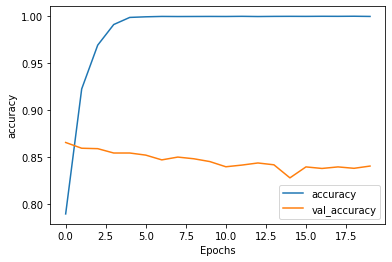

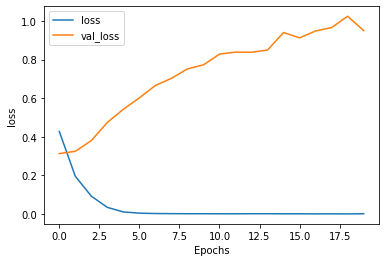

In [13]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [14]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(10000, 16)


In [16]:
import io

# Open writeable files
out_v = io.open('vecs_no_cb.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_no_cb.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

Visualize vector at https://projector.tensorflow.org/